<a href="https://colab.research.google.com/github/Sahanave/WomenWhoCodeHSIDemo/blob/main/HSIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hyperspectral Images dataset**

Thanking the authors of the paper [Hyperspectral Image Dataset for Benchmarking on Salient Object Detection](https://arxiv.org/abs/1806.11314). 

In [2]:
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import color
import cv2


### Objective

Object detection using supervised or unsupervised approaches on colour images is a huge field. Recently, a few studies demonstrated that efficient salient object detection can also be implemented by using visible spectrum of hyperspectral images. 

**What we have** : A hyperspectral salient object detection dataset with a collection of 60 hyperspectral images with their respective ground-truth binary images and corresponding colour images (sRGB).

Wavelength range : 350 - 1100 nm (151 bands)

Objects : (no description in the paper) : Foreground


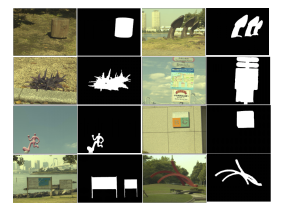

## Dataset 

In [3]:
!wget http://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip
!unzip HS-SOD.zip


--2020-11-02 04:37:57--  http://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip
Resolving data.airc.aist.go.jp (data.airc.aist.go.jp)... 163.220.33.57
Connecting to data.airc.aist.go.jp (data.airc.aist.go.jp)|163.220.33.57|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip [following]
--2020-11-02 04:37:57--  https://data.airc.aist.go.jp/HS-SOD/HS-SOD.zip
Connecting to data.airc.aist.go.jp (data.airc.aist.go.jp)|163.220.33.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5549583419 (5.2G) [application/zip]
Saving to: ‘HS-SOD.zip’

HS-SOD.zip          100%[===================>]   5.17G  68.6MB/s    in 80s     

2020-11-02 04:39:17 (66.5 MB/s) - ‘HS-SOD.zip’ saved [5549583419/5549583419]

Archive:  HS-SOD.zip
   creating: HS-SOD/
  inflating: HS-SOD/LICENSE          
   creating: HS-SOD/hyperspectral/
  inflating: HS-SOD/hyperspectral/0082.mat  
  inflating: HS-SOD/hyperspectral/0079.mat  
  infl

# Investigate the labels

In [4]:
 
 Paths = [path for path in Path('HS-SOD').glob('*')]

In [5]:
print(Paths)

[PosixPath('HS-SOD/ground_truth'), PosixPath('HS-SOD/LICENSE'), PosixPath('HS-SOD/color'), PosixPath('HS-SOD/hyperspectral')]


In [6]:
ground_truth =[str(path)for path in Path('HS-SOD/ground_truth').glob('*')]

In [7]:
rgb_images = [str(path) for path in Path('HS-SOD/color').glob('*')]

In [8]:
hsi_images = [str(path) for path in Path('HS-SOD/hyperspectral').glob('*')]

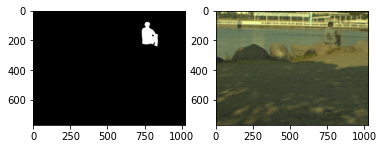

(768, 1024, 3)


In [9]:
image1 = plt.imread('HS-SOD/ground_truth/0079.jpg')
image2 = plt.imread('HS-SOD/color/0079.jpg')
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)
plt.show()
print(image1.shape)

In [10]:
# It is to be noted that the authors did the saved hyper-cubes for each scene in ”.mat” file format after sensor dark-noise correction. 

### `Visualize the bands`



HS-SOD/hyperspectral/0047.mat
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)
(768, 1024)


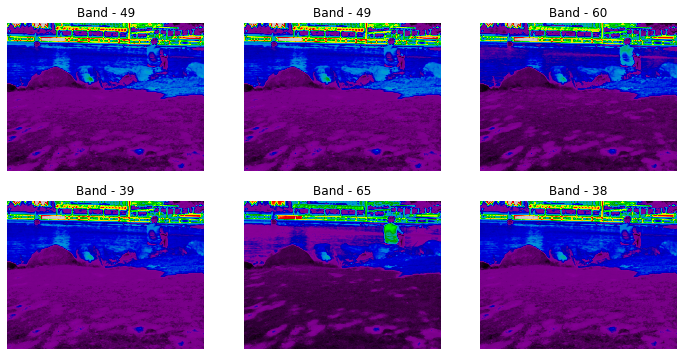

In [11]:
fig = plt.figure(figsize = (12, 6))
with h5py.File('HS-SOD/hyperspectral/0079.mat', 'r') as f:
        print(hsi_images[0])
        data = np.array(f['hypercube'])
        data = np.swapaxes(data,0,2)   
for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(data.shape[2])
    band_shot = data[:,:,q]
    print(band_shot.shape)
    plt.imshow(band_shot, cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.show()

# Prepare

In [12]:
def get_pixel_level_dataset(set_of_hsi):
  Complete_data = []
  Label = []
  file_names = []
  for index,inputs in enumerate(set_of_hsi):
    with h5py.File(inputs, 'r') as f:
        data = np.array(f['hypercube'])
        data = np.swapaxes(data,0,2) 
        y=[]
        scale_percent = 100 # percent of original size
        data = np.array(data)
        width = int(data.shape[1] * scale_percent / 100)
        height = int(data.shape[0] * scale_percent / 100)
        dim = (width, height)
        new_data = np.zeros((height,width,data.shape[2]),dtype=np.uint8)
        for i in range(data.shape[2]):
          new_data[:,:,i] = cv2.resize(data[:,:,i],dim)
        new_data = np.array(new_data)
        new_data = new_data.reshape(height*width,data.shape[2])
        GT = plt.imread(ground_truth[index])
        GT = np.array(GT)
        GT = cv2.resize(GT[:,:,0],dim)
        thresh = 127
        GT = cv2.threshold(GT, thresh, 255, cv2.THRESH_BINARY)[1]
        y = GT.reshape(-1)
        Complete_data.extend(new_data)
        Label.extend(y)
        for i in range(len(y)):
          file_names.append(inputs)
  return file_names, Complete_data, Label    
        

In [13]:
filenames, Training_set_X, Training_set_Y = get_pixel_level_dataset(['HS-SOD/hyperspectral/0079.mat'])

Show me the plots :) 

In [14]:
 New_data = pd.DataFrame(Training_set_X,columns=['Band_'+str(i) for i in range(81)])

In [15]:
New_data['Filename'] = filenames
New_data ['Label'] = Training_set_Y

In [16]:
display(New_data)

,Band_0,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Band_11,Band_12,Band_13,Band_14,Band_15,Band_16,Band_17,Band_18,Band_19,Band_20,Band_21,Band_22,Band_23,Band_24,Band_25,Band_26,Band_27,Band_28,Band_29,Band_30,Band_31,Band_32,Band_33,Band_34,Band_35,Band_36,Band_37,Band_38,Band_39,...,Band_43,Band_44,Band_45,Band_46,Band_47,Band_48,Band_49,Band_50,Band_51,Band_52,Band_53,Band_54,Band_55,Band_56,Band_57,Band_58,Band_59,Band_60,Band_61,Band_62,Band_63,Band_64,Band_65,Band_66,Band_67,Band_68,Band_69,Band_70,Band_71,Band_72,Band_73,Band_74,Band_75,Band_76,Band_77,Band_78,Band_79,Band_80,Filename,Label
0,16,36,24,60,88,112,144,196,4,72,124,224,44,204,84,184,29,157,249,121,21,121,81,213,117,45,165,185,125,165,189,221,229,205,181,185,89,49,241,185,...,37,69,121,113,117,89,97,25,241,237,221,117,81,89,93,81,85,105,57,149,45,253,25,65,21,72,4,184,252,72,204,17,73,188,176,120,117,221,HS-SOD/hyperspectral/0079.mat,0
1,16,36,32,48,88,120,140,224,8,96,104,240,32,208,88,232,45,201,57,189,61,157,133,221,169,73,133,197,113,125,149,209,173,165,149,97,85,13,221,153,...,229,57,137,153,97,129,73,9,237,253,9,121,149,117,113,97,113,109,65,141,29,49,61,105,61,124,12,208,36,136,13,149,157,17,0,144,185,29,HS-SOD/hyperspectral/0079.mat,0
2,20,16,36,64,88,108,140,220,0,76,92,208,20,172,60,192,57,185,45,177,89,149,161,1,145,129,221,205,117,177,141,22,161,165,193,149,113,85,237,221,...,13,141,209,1,117,161,169,93,85,57,77,253,253,229,25,17,33,249,173,73,161,177,161,253,253,232,136,52,168,21,193,49,65,73,52,45,85,169,HS-SOD/hyperspectral/0079.mat,0
3,20,32,36,56,84,96,132,208,240,64,88,216,12,196,36,192,25,205,65,197,37,185,209,5,141,161,221,42,209,254,10,110,66,2,82,46,221,161,77,53,...,145,13,137,97,41,105,89,41,9,33,1,197,129,193,245,173,237,201,89,65,89,157,157,193,113,149,17,168,65,229,145,49,85,189,184,181,181,89,HS-SOD/hyperspectral/0079.mat,0
4,20,28,28,44,64,96,120,200,212,48,72,172,12,180,36,184,17,165,33,157,89,189,241,69,234,233,22,62,50,66,78,150,122,98,122,90,14,197,121,141,...,25,81,213,225,157,189,209,145,129,145,93,57,225,233,53,245,41,85,5,45,137,173,229,233,213,209,29,208,133,85,81,73,113,57,212,225,205,81,HS-SOD/hyperspectral/0079.mat,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786427,4,8,20,4,8,20,12,8,16,52,40,44,60,60,80,92,104,100,132,136,140,156,148,160,164,180,188,204,180,200,208,204,220,216,252,236,4,248,244,248,...,240,224,240,232,236,232,244,4,232,228,212,232,204,180,212,196,208,188,196,152,140,156,192,164,192,180,140,152,164,180,212,216,216,208,112,108,176,180,HS-SOD/hyperspectral/0079.mat,0
786428,8,12,8,0,0,12,32,16,40,32,32,32,44,56,72,80,116,116,132,124,144,160,140,144,176,184,184,180,204,200,220,228,240,228,240,0,0,236,244,236,...,228,240,240,236,252,236,224,236,204,204,224,216,192,196,188,204,180,192,188,172,132,148,160,160,176,148,144,128,144,148,208,208,232,196,124,112,176,188,HS-SOD/hyperspectral/0079.mat,0
786429,4,4,0,4,4,16,16,28,28,32,36,44,44,40,68,80,92,124,120,120,152,140,140,156,176,180,196,200,208,212,196,228,240,244,236,232,240,4,240,244,...,228,224,232,232,240,240,248,212,220,212,216,204,204,192,168,192,184,192,176,160,156,128,152,168,172,140,128,116,140,168,188,196,204,184,92,124,160,164,HS-SOD/hyperspectral/0079.mat,0
786430,4,16,12,12,0,16,16,24,24,32,32,36,44,68,48,96,88,92,116,124,156,148,164,136,160,184,164,188,176,188,220,216,240,212,248,232,248,240,252,232,...,204,228,252,248,236,232,228,240,212,204,200,212,176,172,188,172,180,180,172,148,136,152,140,156,188,148,144,128,148,164,196,208,220,184,108,120,168,168,HS-SOD/hyperspectral/0079.mat,0


In [17]:
New_data.shape

(786432, 83)

In [20]:
print(set(New_data['Label']))
columns=[str(i) for i in range(81)]
col = columns + ['Label']

{0, 255}


In [22]:
New_data.columns
columns=['Band_'+str(i) for i in range(81)]

In [23]:
Object_signature = New_data[New_data['Label']==255][columns]
print("The object pixels constitute {}% of the data".format(round(((len(Object_signature)/New_data.shape[0])*100)),2))

The object pixels constitute 35% of the data


In [24]:
Background_signature = New_data[New_data['Label']==0][columns]
print("The Background pixels constitute {}% of the data".format(round(((len(Background_signature)/New_data.shape[0])*100)),2))

The Background pixels constitute 65% of the data


In [25]:
Object_signature = Object_signature.mean(axis=0)
Background_signature = Background_signature.mean(axis=0)

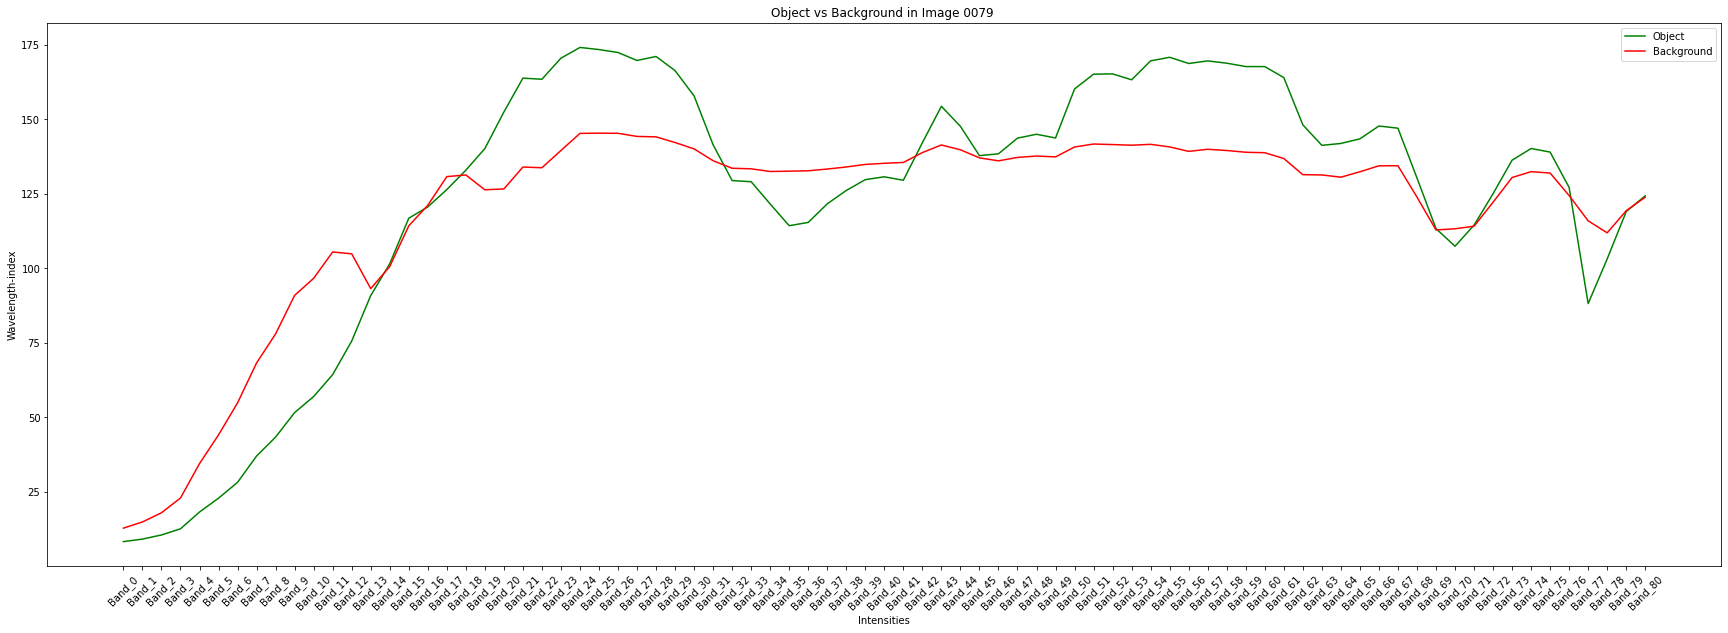

In [27]:
plt.figure(figsize=(30,10))
plt.plot(columns, Object_signature, label='Object',color='green')
plt.plot(columns, Background_signature, label='Background',color='red')
plt.xlabel('Intensities')
plt.ylabel('Wavelength-index')
plt.title('Object vs Background in Image 0079 ')
plt.xticks(rotation=45)
plt.legend()
plt.show()
